In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Load the merged DataFrame
df = pd.read_csv("uk_financial_and_economic_data.csv", index_col=0, parse_dates=True)

In [7]:
# --- 1. Data Preparation: Start from SONIA's inception and handle NaNs ---

start_date_sonia = '2014-01-02'
df = df[df.index >= start_date_sonia].copy()

print(f"\n--- Data Prepared from {start_date_sonia} onwards ---")
print(f"Initial shape: {df.shape}")
print(df.head())
print(df.info())

# Handle NaNs:
# For stock prices, ffill then bfill for short gaps (weekends/holidays) is common.
# For longer gaps (e.g., if a stock was delisted/not yet listed for a period within the SONIA range),
# you might need to drop rows or impute more robustly.
# Let's target specific stock columns for this fill.
stock_cols = ['^FTSE', 'LLOY.L', 'BARC.L', 'AV.L', 'PSN.L', 'LAND.L']
for col in stock_cols:
    if col in df.columns:
        df[col] = df[col].ffill().bfill() # ffill propagates, bfill handles initial NaNs

# For other features (Bank Rate, SONIA, Gilts), ffill should have already been applied during merging,
# but bfill might be useful for any NaNs at the very start of the filtered period if ffill couldn't reach them.
# (Though given our merging, they should be fully filled from their respective start dates to the max date)
for col_prefix in ['Bank_Rate', 'SONIA_Rate', 'Gilt_']:
    for col in df.columns:
        if col.startswith(col_prefix):
            df[col] = df[col].ffill().bfill() # Ensures no NaNs in these critical features

# Drop any remaining rows with NaNs (e.g., if a stock just has no data at all within the range)
initial_rows = df.shape[0]
df = df.dropna()
print(f"Rows dropped due to NaNs after filling: {initial_rows - df.shape[0]}")
print(f"Final shape after NaN handling: {df.shape}")
print(df.isnull().sum().sum()) # Should be 0 if all NaNs are handled


--- Data Prepared from 2014-01-02 onwards ---
Initial shape: (4229, 12)
                  ^FTSE     LLOY.L      BARC.L        AV.L        PSN.L  \
2014-01-02  6717.899902  78.781693  270.183624  436.252319  1247.783569   
2014-01-03  6730.700195  79.418953  271.977936  434.975891  1250.764404   
2014-01-04          NaN        NaN         NaN         NaN          NaN   
2014-01-05          NaN        NaN         NaN         NaN          NaN   
2014-01-06  6730.700195  79.767441  276.613068  434.975891  1281.561157   

                 LAND.L  Bank_Rate  SONIA_Rate  Gilt_Short_Yield  \
2014-01-02  1006.038574        0.5      0.4264              1.73   
2014-01-03  1017.712097        0.5      0.4256              1.73   
2014-01-04          NaN        0.5      0.4256              1.73   
2014-01-05          NaN        0.5      0.4256              1.73   
2014-01-06  1020.364990        0.5      0.4304              1.73   

            Gilt_Medium_Yield  Gilt_Long_Yield  Gilt_Ultra-Long_Yie

In [8]:
# --- 2. Feature Engineering ---

# Target Variable: Next day's percentage change in ^FTSE
df['FTSE_Next_Day_Return'] = df['^FTSE'].pct_change().shift(-1) * 100 # In percentage terms
# Drop the last row as its target will be NaN
df = df.dropna(subset=['FTSE_Next_Day_Return'])

# Lagged features for predictor variables (e.g., previous day's value)
# This is crucial as we predict tomorrow based on today's/past info.
# Let's create lags for economic indicators and stock returns
for col in ['Bank_Rate', 'SONIA_Rate', 'Gilt_Short_Yield', 'FTSE_Next_Day_Return']: # Lagging FTSE_Next_Day_Return for previous day's return
    df[f'{col}_lag1'] = df[col].shift(1)
for col in stock_cols: # Lagging raw stock prices
        df[f'{col}_lag1'] = df[col].shift(1)


# Calendar features (Day of week, Month of year)
df['day_of_week'] = df.index.dayofweek # Monday=0, Sunday=6
df['month_of_year'] = df.index.month

# Drop the first row now, as lagged features will be NaN there
df = df.dropna()
print(f"Shape after feature engineering: {df.shape}")

# Define X (Features) and y (Target)
y = df['FTSE_Next_Day_Return']
X = df.drop(columns=['FTSE_Next_Day_Return'] + stock_cols) # Drop the original stock columns as we're using lagged.
# Also drop original Bank_Rate etc. if you only want to use lagged versions
# For simplicity, let's keep original economic indicators too, and add their lagged versions
# Make sure to not include any future information in X

# Final feature set - ensure no original target or future data
# Filter columns to only include those relevant for prediction
final_features = [col for col in X.columns if not col.startswith(('^FTSE', 'LLOY.L', 'BARC.L', 'AV.L', 'PSN.L', 'LAND.L'))]
# Re-add relevant lagged stock features explicitly
final_features.extend([f'{col}_lag1' for col in stock_cols])
final_features.extend(['day_of_week', 'month_of_year'])
final_features.extend(['Bank_Rate', 'SONIA_Rate', 'Gilt_Short_Yield', 'Gilt_Medium_Yield', 'Gilt_Long_Yield', 'Gilt_Ultra-Long_Yield'])
# Remove duplicates and ensure order
final_features = list(dict.fromkeys(final_features))
# Make sure we remove the original FTSE return column if it got added mistakenly
final_features = [f for f in final_features if f != 'FTSE_Next_Day_Return']


X = df[final_features] # Select only the prepared features
# Drop any feature columns that might still have NaNs (e.g. if a stock_lag1 was missing in some very first rows)
X = X.dropna()
y = y.loc[X.index] # Align y to X's index after any drops in X

print(f"\nFeatures (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print("\nFeatures (X) head:")
print(X.head())

Shape after feature engineering: (4227, 25)

Features (X) shape: (4227, 18)
Target (y) shape: (4227,)

Features (X) head:
            Bank_Rate  SONIA_Rate  Gilt_Short_Yield  Gilt_Medium_Yield  \
2014-01-03        0.5      0.4256              1.73               2.86   
2014-01-04        0.5      0.4256              1.73               2.86   
2014-01-05        0.5      0.4256              1.73               2.86   
2014-01-06        0.5      0.4304              1.73               2.86   
2014-01-07        0.5      0.4332              1.73               2.86   

            Gilt_Long_Yield  Gilt_Ultra-Long_Yield  Bank_Rate_lag1  \
2014-01-03             3.58                    3.5             0.5   
2014-01-04             3.58                    3.5             0.5   
2014-01-05             3.58                    3.5             0.5   
2014-01-06             3.58                    3.5             0.5   
2014-01-07             3.58                    3.5             0.5   

            

In [9]:
# --- 3. Train-Test Split (Chronological) ---
# Common split: 80% train, 20% test
split_ratio = 0.8
split_index = int(len(df) * split_ratio)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print(f"\nTrain set size: {len(X_train)} ({X_train.index.min().strftime('%Y-%m-%d')} to {X_train.index.max().strftime('%Y-%m-%d')})")
print(f"Test set size: {len(X_test)} ({X_test.index.min().strftime('%Y-%m-%d')} to {X_test.index.max().strftime('%Y-%m-%d')})")


Train set size: 3381 (2014-01-03 to 2023-04-06)
Test set size: 846 (2023-04-07 to 2025-07-30)


In [12]:
# --- 4. Model Selection and Training ---
# Using RandomForestRegressor as a robust starting point
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1) # n_jobs=-1 uses all available cores

print("\n--- Training Model ---")
model.fit(X_train, y_train)
print("Model training complete.")


--- Training Model ---
Model training complete.


In [13]:
# --- 5. Prediction ---
y_pred = model.predict(X_test)

In [15]:
# --- 6. Evaluation ---
rmse = mean_squared_error(y_test, y_pred) # RMSE
r2 = r2_score(y_test, y_pred) # R-squared

print(f"\n--- Model Evaluation ---")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2): {r2:.4f}")


--- Model Evaluation ---
Root Mean Squared Error (RMSE): 0.3781
R-squared (R2): -0.8845


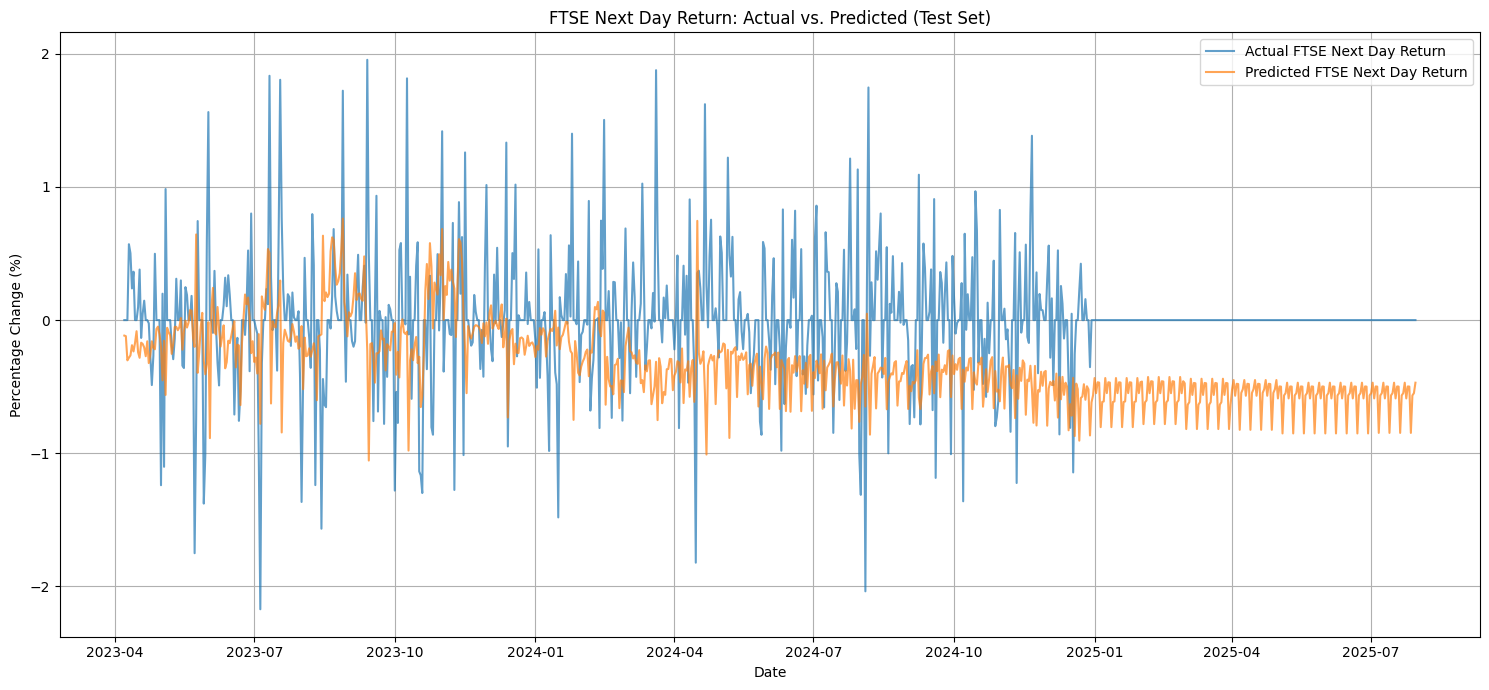

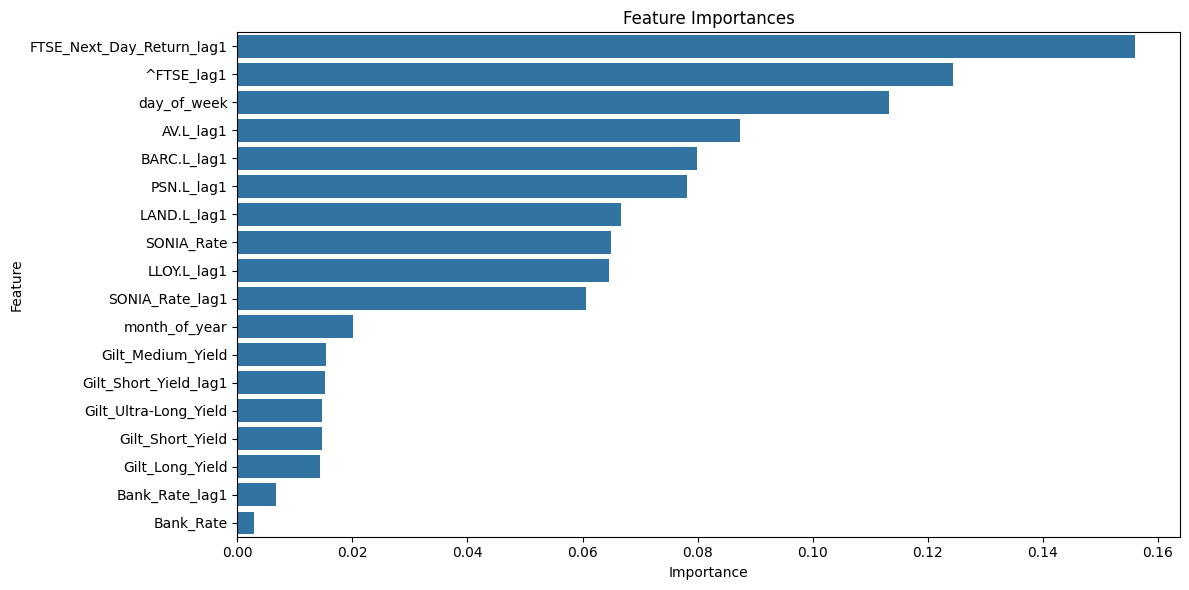


--- Top 10 Feature Importances ---
FTSE_Next_Day_Return_lag1    0.156038
^FTSE_lag1                   0.124326
day_of_week                  0.113298
AV.L_lag1                    0.087384
BARC.L_lag1                  0.079976
PSN.L_lag1                   0.078232
LAND.L_lag1                  0.066602
SONIA_Rate                   0.064875
LLOY.L_lag1                  0.064520
SONIA_Rate_lag1              0.060599
dtype: float64


In [16]:
# --- Visualize Predictions vs Actual ---
plt.figure(figsize=(15, 7))
plt.plot(y_test.index, y_test, label='Actual FTSE Next Day Return', alpha=0.7)
plt.plot(y_test.index, y_pred, label='Predicted FTSE Next Day Return', alpha=0.7)
plt.title('FTSE Next Day Return: Actual vs. Predicted (Test Set)')
plt.xlabel('Date')
plt.ylabel('Percentage Change (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Feature Importance ---
# For tree-based models, feature importance can be insightful
if hasattr(model, 'feature_importances_'):
    feature_importances = pd.Series(model.feature_importances_, index=X.columns)
    sorted_importances = feature_importances.sort_values(ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=sorted_importances.values, y=sorted_importances.index)
    plt.title('Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

    print("\n--- Top 10 Feature Importances ---")
    print(sorted_importances.head(10))